# Laboratorio 8. Detección de Anomalías
José Antonio Mérida Castejón

Joaquín Puente

# Imports / Librerías y Reproducibilidad
Antes de iniciar, vamos a importar algunas librerías para utilizar dentro de este Notebook. Además, utilizamos un seed fijo para que los resultados sean reproducibles utilizando np.random.seed y tf.random.set_seed.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## 1. Carga del Conjunto de Datos

### Importación Utilizando Datasets de SKLearn
Importando sklearn.datasets, podemos llamar la función fetch_covtype que nos provee datos en un "bunch". Dónde podemos extraer diferentes partes del datasetcomo features y variables de respuesta en dataframes separados.

In [2]:

from sklearn.datasets import fetch_covtype

cov = fetch_covtype(as_frame=True)

# Set de datos completo
df = cov.frame

# Features
x = cov.data

# Variable de Respuesta
y = cov.target

df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


Luego de explorar la tabla de df.head(), podemos ver que el dataset fue importado exitosamente.

### Escala de Variables Numéricas
Para identificar las columnas numéricas, nos apoyamos de una función auxiliar que identifica columnas dónde se contienen únicamente valores binarios. También evitamos escalar la variable objetivo, y luego utilizamos el StandardScaler para escalar las columnas deseadas.

In [3]:
from sklearn.preprocessing import StandardScaler

# Columna Objetivo y de Features
target_col = y.name if hasattr(y, "name") and y.name in df.columns else None
feature_cols = [c for c in df.columns if c != target_col]

# Identificar con solo 1s y 0s
binary_cols = [c for c in feature_cols if set(df[c].dropna().unique()) <= {0, 1}]
num_cols    = [c for c in feature_cols if c not in binary_cols]

# Escalar features in-place
scaler = StandardScaler()
df.loc[:, num_cols] = scaler.fit_transform(df[num_cols])

df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,-1.297805,-0.935157,-1.482820,-0.053767,-0.796273,-1.180146,0.330743,0.439143,0.142960,3.246283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,-1.319235,-0.890480,-1.616363,-0.270188,-0.899197,-1.257106,0.293388,0.590899,0.221342,3.205504,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,-0.554907,-0.148836,-0.681563,-0.006719,0.318742,0.532212,0.816364,0.742654,-0.196691,3.126965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,-0.622768,-0.005869,0.520322,-0.129044,1.227908,0.474492,0.965786,0.742654,-0.536343,3.194931,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,-1.301377,-0.988770,-1.616363,-0.547771,-0.813427,-1.256464,0.293388,0.540313,0.195215,3.165479,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


Analizando la tabla, nuestras variables fueron escaladas exitosamente.

### Descripción de Variables
Este conjunto de datos contiene información sobre la cobertura forestal en ciertas áreas de EEUU. A continuación detallamos un poco el significado de cada una de las variables dentro del dataset dónde los intervalos se encuentran dados conforme a los datos originales, luego del scaling estos cambian.

* **Elevation** — cuantitativo — **m** — Elevación en metros.
* **Aspect** — cuantitativo — **acimut (°)** — Orientación en grados de acimut.
* **Slope** — cuantitativo — **°** — Inclinación del terreno en grados.
* **Horizontal_Distance_To_Hydrology** — cuantitativo — **m** — Distancia horizontal a la hidrografía superficial más cercana.
* **Vertical_Distance_To_Hydrology** — cuantitativo — **m** — Distancia vertical a la hidrografía superficial más cercana.
* **Horizontal_Distance_To_Roadways** — cuantitativo — **m** — Distancia horizontal a la carretera más cercana.
* **Hillshade_9am** — cuantitativo — **índice 0–255** — Sombreado a las 9 a. m. (solsticio de verano).
* **Hillshade_Noon** — cuantitativo — **índice 0–255** — Sombreado al mediodía (solsticio de verano).
* **Hillshade_3pm** — cuantitativo — **índice 0–255** — Sombreado a las 3 p. m. (solsticio de verano).
* **Horizontal_Distance_To_Fire_Points** — cuantitativo — **m** — Distancia horizontal al punto de ignición de incendio más cercano.
* **Wilderness_Area** *(4 columnas binarias)* — cualitativo — **0/1** — Indicadores de pertenencia a área silvestre (one-hot).
* **Soil_Type** *(40 columnas binarias)* — cualitativo — **0/1** — Indicadores de tipo de suelo (one-hot).
* **Cover_Type** *(7 tipos)* — entero — **1–7** — Tipo de cobertura forestal.


## 2. Etiqueta de Datos Normales / Anormales
Aquí simplemente podemos agregar una nueva columna a nuestro DataFrame

In [4]:
# Crear la etiqueta
df["is_anomaly"] = (df["Cover_Type"] != 2).astype(int)

# Verificación
df["is_anomaly"].value_counts().rename({0:"normal", 1:"anomalo"})


,count
is_anomaly,
anomalo,297711
normal,283301


Podemos identificar que la nueva columna fue agregada con éxito.

## 3. División Train / Val / Test
Para esta división, buscamos entrenar a nuestros modelos únicamente con datos "normales". Es decir, no incluir datos anómalos hasta el conjunto de prueba. Lo que buscamos es que el modelo aprenda de la "normalidad" para luego identificar que tan alejados de esta normalidad se encuentran los valores. Posteriormente, estableceremos un umbral que nos ayude a detectar de manera más precisa los valores fuera de lo normal. Adicionalmente, buscamos que dentro del conjunto de prueba existiera una distribución entre clases balanceada así nos evitamos problemas de métricas a futuro.

In [5]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Partir normales / anómalos
df_norm = df[df["is_anomaly"] == 0]
df_anom = df[df["is_anomaly"] == 1]

# Holdout de NORMALES para test
df_trainval_norm, df_test_norm = train_test_split(
    df_norm, test_size=0.20, random_state=42, shuffle=True
)

# De lo que queda, TRAIN/VAL (solo normales)
df_train_norm, df_val_norm = train_test_split(
    df_trainval_norm, test_size=0.30, random_state=42, shuffle=True
)

# Empareja el # de normales del holdout con el # de anomalías disponibles
per_class = min(len(df_test_norm), len(df_anom))

df_test = pd.concat([
    df_test_norm.sample(n=per_class, random_state=42),
    df_anom.sample(n=per_class, random_state=42)
], axis=0).sample(frac=1.0, random_state=42)

prev_test = (df_test["is_anomaly"] == 1).mean()

df_train_norm.shape, df_val_norm.shape, df_test.shape, prev_test

assert (df_train_norm["is_anomaly"].sum()==0) and (df_val_norm["is_anomaly"].sum()==0), "Hay anómalos en train/val"
print("Test % anómalos:", round((df_test["is_anomaly"]==1).mean(), 4))

Test % anómalos: 0.5


Al ver los tamaños, podemos ver que nuestros conjuntos de datos fueron creados exitosamente. Sin embargo, nos podemos dar cuenta que la sumatoria de todos sus tamaños es inferior al tamaño del dataset original. Esta fue una decisión que tomamos para poder mantener el balanceo de clases en el conjunto de prueba, de esta manera tenemos una distribución similar a la original y cercana al 50/50 para poder analizar mejor los modelos. Consideramos que la cantidad de datos en el conjunto de prueba es suficiente como para poder tomar esta decisión. Adicionalmente, podemos separar los conjuntos en sus X e Y.

In [6]:
X_cols = [c for c in df.columns if c not in ["Cover_Type", "is_anomaly"]]

# Train/Val: SOLO normales
X_train = df_train_norm[X_cols].to_numpy()
y_train = df_train_norm["is_anomaly"].to_numpy()

X_val   = df_val_norm[X_cols].to_numpy()
y_val   = df_val_norm["is_anomaly"].to_numpy()

# Test: mixto (50/50 por construcción)
X_test  = df_test[X_cols].to_numpy()
y_test  = df_test["is_anomaly"].to_numpy()

# Input size para el Autoencoder (y demás modelos)
input_dim = X_train.shape[1]

## 4. Modelo de Autocodificador

### Encoder Simétrico
El encoder se entrena únicamente con observaciones normales para aprender una representación compacta de la “normalidad”. Su objetivo es capturar las regularidades y descartar ruido, de modo que ejemplos típicos queden bien representados en el espacio latente mientras que casos atípicos queden mal codificados. Esto favorece que, más adelante, las muestras alejadas de la distribución aprendida produzcan errores mayores al reconstruirse.

In [7]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers

input_dim = X_train.shape[1]

hidden_dims = [256, 128, 64]  # más capacidad
bottleneck = 32
dropout_rate = 0.1

inputs = keras.Input(shape=(input_dim,), name="input")
x = inputs
for h in hidden_dims:
    x = layers.Dense(h, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-5))(x)
    x = layers.BatchNormalization()(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)

z = layers.Dense(bottleneck, activation="relu", name="bottleneck")(x)

x = z
for h in reversed(hidden_dims):
    x = layers.Dense(h, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-5))(x)
    x = layers.BatchNormalization()(x)

outputs = layers.Dense(input_dim, activation="linear", name="reconstruction")(x)

autoencoder = keras.Model(inputs, outputs, name="autoencoder")


autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstruction (Dense)          │ (None, 54)             │        13,878 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,230 (461.84 KB)

 Trainable params: 116,438 (454.84 KB)

 Non-trainable params: 1,792 (7.00 KB)

### Compilación
Compilamos el modelo con **Adam** y **MSE** como pérdida/métrica para optimizar la reconstrucción. Usamos **early stopping** monitoreando `val_loss` para detener cuando ya no mejora (paciencia 5) y **restaurar los mejores pesos**, evitando sobreajuste. Además, aplicamos **ReduceLROnPlateau** para **bajar la tasa de aprendizaje** si la validación se estanca, estabilizando el entrenamiento y mejorando la convergencia.

In [8]:
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    loss="mse",
    metrics=["mse"]
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=7, mode="min", restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, verbose=1
)

### Entrenamiento
Entrenamos el autoencoder con un tamaño de lote 1024 y hasta 100 épocas, confiando en early stopping y reducción de LR para evitar sobreajuste y estabilizar la convergencia. El entrenamiento usa solo normales (input=target) y valida también con normales, coherente con el objetivo de aprender la normalidad. El mejor val_loss (MSE) nos servirá luego para calibrar el umbral de detección y comparar configuraciones de modelo.

In [9]:
batch_size = 1024
epochs = 100

history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("Best val_loss:", min(history.history["val_loss"]))

Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - loss: 0.5903 - mse: 0.5838 - val_loss: 0.1246 - val_mse: 0.1182 - learning_rate: 5.0000e-04
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0710 - mse: 0.0647 - val_loss: 0.0622 - val_mse: 0.0559 - learning_rate: 5.0000e-04
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0551 - mse: 0.0488 - val_loss: 0.0418 - val_mse: 0.0355 - learning_rate: 5.0000e-04
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0472 - mse: 0.0410 - val_loss: 0.0354 - val_mse: 0.0292 - learning_rate: 5.0000e-04
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0419 - mse: 0.0357 - val_loss: 0.0308 - val_mse: 0.0247 - learning_rate: 5.0000e-04
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0376 - mse: 0.0315 - val_loss: 0.0271 - val_mse: 0.0211 - learning_rate: 5.0000e-04
Epoch 7/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0343 - mse: 0.0283 - val_loss: 0.0247 - val_mse: 0.01

### F1 at Umbral
Utilizando la métricas de F1 at Umbral, podemos obtener un valor apto para el umbral que utilizaremos para realizar predicciones

BEST F1 = 0.6944  @ PERCENTILE = P70.000  (THRESHOLD = 0.000513788)


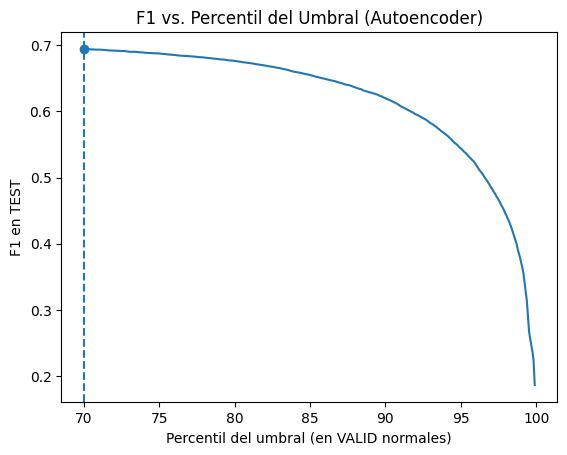

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

X_val_hat  = autoencoder.predict(X_val,  batch_size=2048, verbose=0)
X_test_hat = autoencoder.predict(X_test, batch_size=2048, verbose=0)
val_scores  = np.mean((X_val  - X_val_hat )**2, axis=1)
test_scores = np.mean((X_test - X_test_hat)**2, axis=1)

percentiles = np.linspace(70, 99.9, 400)
f1_vals = []
thrs = []

for p in percentiles:
    thr = np.percentile(val_scores, p)
    thrs.append(thr)
    y_pred = (test_scores > thr).astype(int)
    f1_vals.append(f1_score(y_test, y_pred))

f1_vals = np.array(f1_vals)
thrs = np.array(thrs)

best_ix = int(np.nanargmax(f1_vals))
best_f1 = float(f1_vals[best_ix])
best_pct = float(percentiles[best_ix])
best_thr = float(thrs[best_ix])

print(f"BEST F1 = {best_f1:.4f}  @ PERCENTILE = P{best_pct:.3f}  (THRESHOLD = {best_thr:.6g})")

plt.figure()
plt.plot(percentiles, f1_vals)
plt.scatter(percentiles[best_ix], f1_vals[best_ix], marker="o")
plt.axvline(percentiles[best_ix], linestyle="--")
plt.xlabel("Percentil del umbral (en VALID normales)")
plt.ylabel("F1 en TEST")
plt.title("F1 vs. Percentil del Umbral (Autoencoder)")
plt.show()

En este caso, podemos ver que el umbral más apto se encuentra en el límite inferior de nuestro intervalo de búsqueda (70 percentil). Esto quiere decir que existe una cantidad muy alta de outliers que coinciden con los valores "normales", es decir, hay bastante overlap entre ambas clases. A futuro, se podría considerar probar con umbrales más bajos, sin embargo basados en la curva predecir que encontraremos un plateau.

Best threshold: 0.000513788  (percentile P70.000 on VALID normals)
              precision    recall  f1-score   support

      Normal       0.69      0.70      0.70     56661
     Anómalo       0.70      0.69      0.69     56661

    accuracy                           0.70    113322
   macro avg       0.70      0.70      0.70    113322
weighted avg       0.70      0.70      0.70    113322

ROC-AUC: 0.7672 | PR-AUC: 0.7990


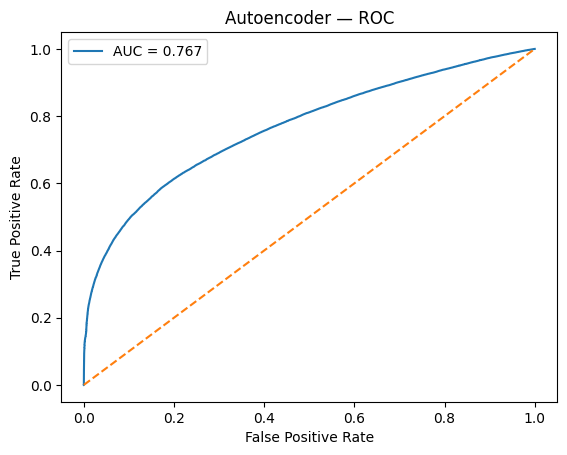

In [11]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, roc_curve
import matplotlib.pyplot as plt

y_pred_best = (test_scores > best_thr).astype(int)

print(f"Best threshold: {best_thr:.6g}  (percentile P{best_pct:.3f} on VALID normals)")
print(classification_report(y_test, y_pred_best, target_names=["Normal","Anómalo"]))
print(f"ROC-AUC: {roc_auc_score(y_test, test_scores):.4f} | PR-AUC: {average_precision_score(y_test, test_scores):.4f}")

fpr, tpr, _ = roc_curve(y_test, test_scores)
auc_roc = roc_auc_score(y_test, test_scores)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Autoencoder — ROC")
plt.legend(); plt.show()

En cuanto a las métricas, podemos darnos cuenta que se obtienen valores similares entre precision y recall para ambas clases. Esto nos indica que la elección de umbral bajo el cual estamos operando es bastante adecuada. Cada clase tiene un Recall de alrededor de 0.7, lo cual es bastante bueno. Adicionalmente, observando la curva ROC este valor se mantiene bastante por encima de un modelo aleatorio. También apoyándonos en los valores de ROC-AUC (0.76) y PR-AUC (0.7990) podemos concluir que el modelo tiene un alto desempeño en cuánto a la detección de outliers.

# 5.1 Isolation Forest
Entrenamos Isolation Forest únicamente con observaciones normales para que el modelo aprenda la distribución de “normalidad”. Aquí solo se construye y ajusta el estimador.

In [12]:
from sklearn.ensemble import IsolationForest

if_model = IsolationForest(
    n_estimators=800,
    max_samples=min(25600, X_train.shape[0]),
    max_features=1.0,
    bootstrap=False,
    contamination="auto",
    n_jobs=-1,
    random_state=42,
    warm_start=False
).fit(X_train)


### F1 at Umbral
Utilizando la métricas de F1 at Umbral, podemos obtener un valor apto para el umbral que utilizaremos para realizar predicciones

[IF] BEST F1 = 0.6434  @ PERCENTILE = P70.000  (THRESHOLD = -0.121584)


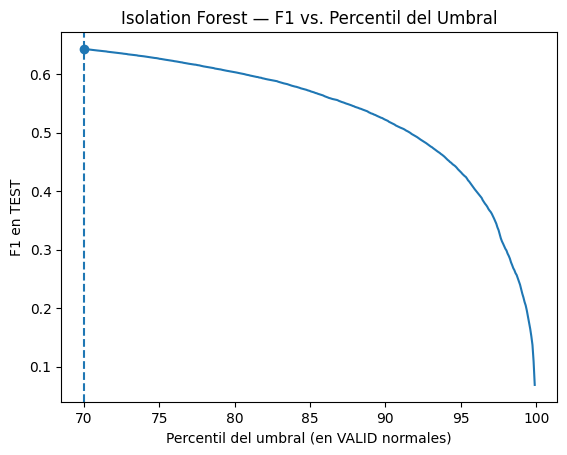

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

val_scores  = -if_model.decision_function(X_val)
test_scores = -if_model.decision_function(X_test)

percentiles = np.linspace(70, 99.9, 400)
f1_vals, thrs = [], []

for p in percentiles:
    thr = np.percentile(val_scores, p)
    thrs.append(thr)
    y_pred = (test_scores > thr).astype(int)
    f1_vals.append(f1_score(y_test, y_pred))

f1_vals = np.array(f1_vals)
thrs = np.array(thrs)

best_ix  = int(np.nanargmax(f1_vals))
best_f1  = float(f1_vals[best_ix])
best_pct = float(percentiles[best_ix])
best_thr = float(thrs[best_ix])

print(f"[IF] BEST F1 = {best_f1:.4f}  @ PERCENTILE = P{best_pct:.3f}  (THRESHOLD = {best_thr:.6g})")

plt.figure()
plt.plot(percentiles, f1_vals)
plt.scatter(percentiles[best_ix], f1_vals[best_ix], marker="o")
plt.axvline(percentiles[best_ix], linestyle="--")
plt.xlabel("Percentil del umbral (en VALID normales)")
plt.ylabel("F1 en TEST")
plt.title("Isolation Forest — F1 vs. Percentil del Umbral")
plt.show()


Aquí tenemos una curva bastante similar al anterior, sin embargo aquí pareciera que tenemos un plateau al que todavía no hemos llegado. A futuro, recomendamos explorar espacios más amplios en cuanto a umbrales para este modelo.

Best threshold: -0.121584  (percentile P70.000 on VALID normals)
              precision    recall  f1-score   support

      Normal       0.65      0.70      0.67     56661
     Anómalo       0.67      0.62      0.64     56661

    accuracy                           0.66    113322
   macro avg       0.66      0.66      0.66    113322
weighted avg       0.66      0.66      0.66    113322

ROC-AUC: 0.7109 | PR-AUC: 0.7386


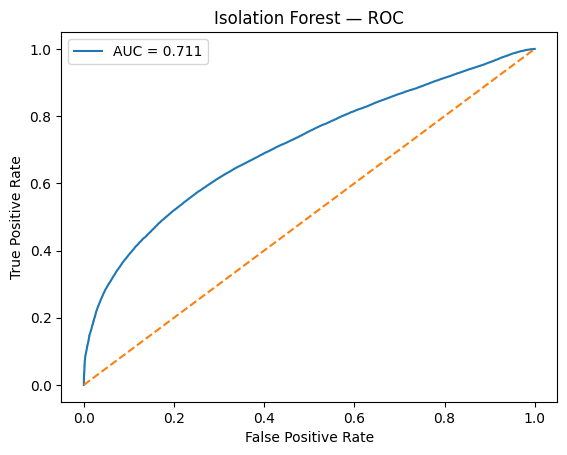

In [14]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, roc_curve
import matplotlib.pyplot as plt

y_pred_best = (test_scores > best_thr).astype(int)

print(f"Best threshold: {best_thr:.6g}  (percentile P{best_pct:.3f} on VALID normals)")
print(classification_report(y_test, y_pred_best, target_names=["Normal","Anómalo"]))
print(f"ROC-AUC: {roc_auc_score(y_test, test_scores):.4f} | PR-AUC: {average_precision_score(y_test, test_scores):.4f}")

fpr, tpr, _ = roc_curve(y_test, test_scores)
auc_roc = roc_auc_score(y_test, test_scores)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Isolation Forest — ROC")
plt.legend(); plt.show()


En cuanto a las métricas, este modelo tiene un rendimiento más bajo en comparación al anterior. La curva ROC se encuentra con una menor separación en comparación al anterior, y además tenemos el valor de AUC de 0.711 en comparación a 0.76. Además, podemos observar que en las métricas se puede observar más diferencia entre una clase y la otra. Sin embargo, el modelo sigue siendo capaz de realizar predicciones bastante bien.

# 5.2 LOF
Entrenamos Local Outlier Factor (LOF) únicamente con observaciones normales para aprender la vecindad típica de la “normalidad”. Configuramos novelty=True para permitir puntajes sobre datos nuevos más adelante, pero aquí solo construimos y ajustamos el modelo.

In [15]:
from sklearn.neighbors import LocalOutlierFactor

lof_model = LocalOutlierFactor(
    n_neighbors=20,
    novelty=True
).fit(X_train)

### F1 at Umbral
Utilizando la métricas de F1 at Umbral, podemos obtener un valor apto para el umbral que utilizaremos para realizar predicciones

[LOF] BEST F1 = 0.7977  @ PERCENTILE = P80.000  (THRESHOLD = -0.383428)


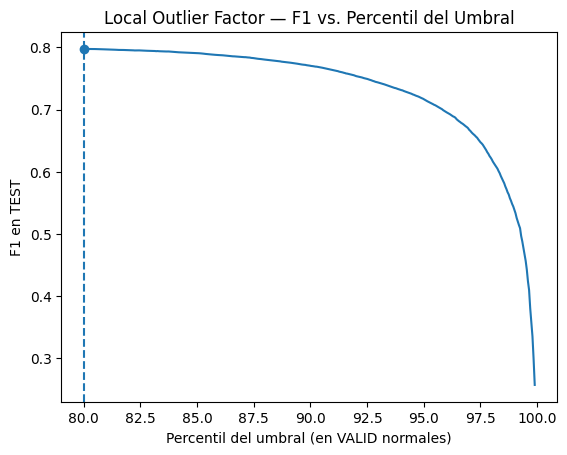

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

val_scores  = -lof_model.decision_function(X_val)
test_scores = -lof_model.decision_function(X_test)

percentiles = np.linspace(80, 99.9, 400)
f1_vals, thrs = [], []

for p in percentiles:
    thr = np.percentile(val_scores, p)
    thrs.append(thr)
    y_pred = (test_scores > thr).astype(int)
    f1_vals.append(f1_score(y_test, y_pred))

f1_vals = np.array(f1_vals)
thrs = np.array(thrs)

best_ix  = int(np.nanargmax(f1_vals))
best_f1  = float(f1_vals[best_ix])
best_pct = float(percentiles[best_ix])
best_thr = float(thrs[best_ix])

print(f"[LOF] BEST F1 = {best_f1:.4f}  @ PERCENTILE = P{best_pct:.3f}  (THRESHOLD = {best_thr:.6g})")

plt.figure()
plt.plot(percentiles, f1_vals)
plt.scatter(percentiles[best_ix], f1_vals[best_ix], marker="o")
plt.axvline(percentiles[best_ix], linestyle="--")
plt.xlabel("Percentil del umbral (en VALID normales)")
plt.ylabel("F1 en TEST")
plt.title("Local Outlier Factor — F1 vs. Percentil del Umbral")
plt.show()

En este caso, podemos ver que llegamos al plateau más rápido en comparación a los demás. Esto nos indica que este modelo tiene un poco más "separadas" las distribuciones de cada clase. Dónde por encima del 80 percentil del puntaje encontramos muy pocos outliers.

Best threshold: -0.383428  (percentile P80.000 on VALID normals)
              precision    recall  f1-score   support

      Normal       0.80      0.80      0.80     56661
     Anómalo       0.80      0.80      0.80     56661

    accuracy                           0.80    113322
   macro avg       0.80      0.80      0.80    113322
weighted avg       0.80      0.80      0.80    113322

ROC-AUC: 0.8775 | PR-AUC: 0.8922


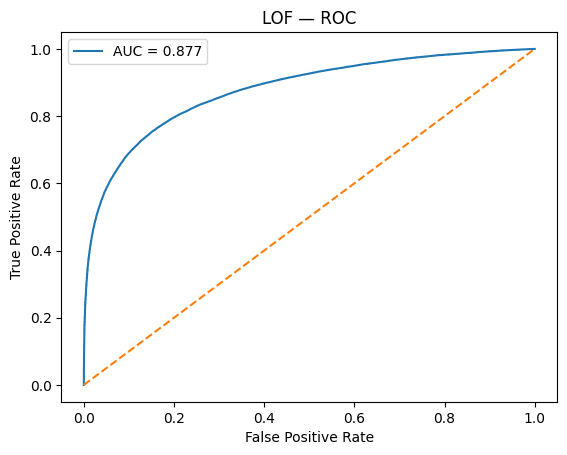

In [17]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, roc_curve
import matplotlib.pyplot as plt

y_pred_best = (test_scores > best_thr).astype(int)

print(f"Best threshold: {best_thr:.6g}  (percentile P{best_pct:.3f} on VALID normals)")
print(classification_report(y_test, y_pred_best, target_names=["Normal","Anómalo"]))
print(f"ROC-AUC: {roc_auc_score(y_test, test_scores):.4f} | PR-AUC: {average_precision_score(y_test, test_scores):.4f}")

fpr, tpr, _ = roc_curve(y_test, test_scores)
auc_roc = roc_auc_score(y_test, test_scores)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("LOF — ROC")
plt.legend(); plt.show()

En cuánto a las métricas, podemos observar que tenemos 0.80 de recall y precisión para cada una de las clases. Esto es una buena señal, ya que nos indica que el modelo puede predecir de manera más precisa y logró encontrar algunos factores que distinguen cada una de las clases. Además, el "overlap" natural dentro de los datos es lo que genera la confusión dentro del modelo y no algún otro factor interno. Observando la curva ROC, este modelo se acerca bastante a una curva ideal y tiene un AUC de 0.877. Este es por mucho el mejor modelo probado dentro de este Notebook.

# 6. Evaluación
Luego de haber cubierto cada modelo individualmente, podemos tomar el mejor modelo y obtener métricas adicionales.

### ROC y AUC

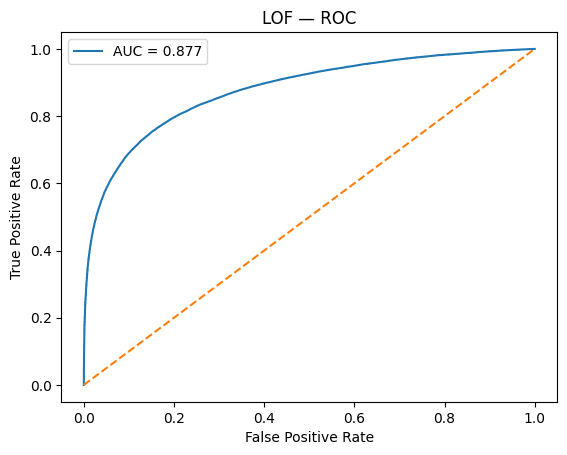

ROC-AUC: 0.8775


In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, test_scores)
auc_roc = roc_auc_score(y_test, test_scores)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LOF — ROC")
plt.legend()
plt.show()

print(f"ROC-AUC: {auc_roc:.4f}")

Como fue mencionado anteriormente, la curva ROC del modelo es bastante prometedora. Se encuentra bastante cercana a una curva ideal, lo cuál indica una capacidad alta de predicción al igual que su puntaje AUC de 0.877

### PR y AUC

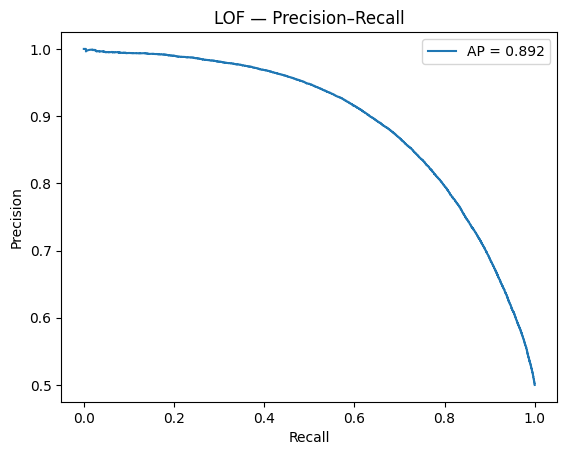

PR-AUC (AP): 0.8922


In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, test_scores)
ap = average_precision_score(y_test, test_scores)

plt.figure()
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("LOF — Precision–Recall")
plt.legend()
plt.show()

print(f"PR-AUC (AP): {ap:.4f}")

Observando la gráfica PR, en este caso el modelo también se acerca bastante a lo que sería una curva ideal. Tenemos un área bajo la curva de 0.89, lo cuál indica una alta capacidad de predecir.

### Precision at K

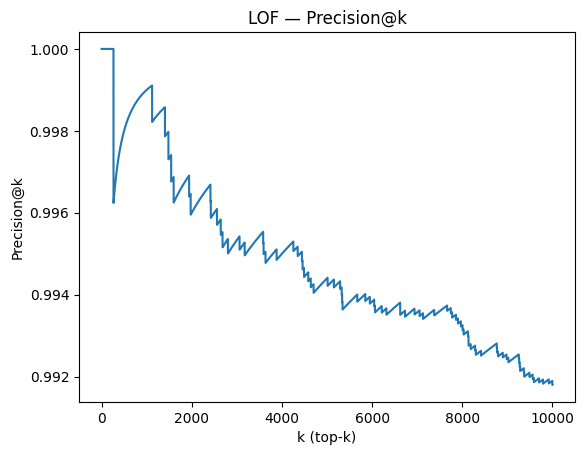

Precision@100: 1.0000
Precision@500: 0.9980
Precision@1000: 0.9990
Precision@5000: 0.9944


In [20]:
import numpy as np
import matplotlib.pyplot as plt

order = np.argsort(test_scores)[::-1]
y_sorted = y_test[order]

ks = np.arange(1, len(y_sorted) + 1)
prec_at_k = np.cumsum(y_sorted) / ks

K_max = min(10000, len(y_sorted))
plt.figure()
plt.plot(ks[:K_max], prec_at_k[:K_max])
plt.xlabel("k (top-k)")
plt.ylabel("Precision@k")
plt.title("LOF — Precision@k")
plt.show()

for K in [100, 500, 1000, 5000]:
    if K <= len(y_sorted):
        print(f"Precision@{K}: {prec_at_k[K-1]:.4f}")

En cuánto a precision at K, el modelo mantiene una precisión sumamente alta para estos valores más extremos. En la gráfica, cubrimos desde 0 - 10,000 valores y el modelo tuvo valores de precisión de 99.2%. Podemos decir que el modelo es sumamente preciso cuándo los valores son extremos, en otras palabras los "más outliers" es más probable que sean clasificados de manera correcta por este modelo. Apoyando el análisis realizado anteriormente, dónde consideramos que los errores de clasificación vienen del "área en común" entre los outliers y los datos normales.